# 11. 어제 오른 내 주식, 과연 내일은?

## STEP 1 : 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv' # 삼성전자
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

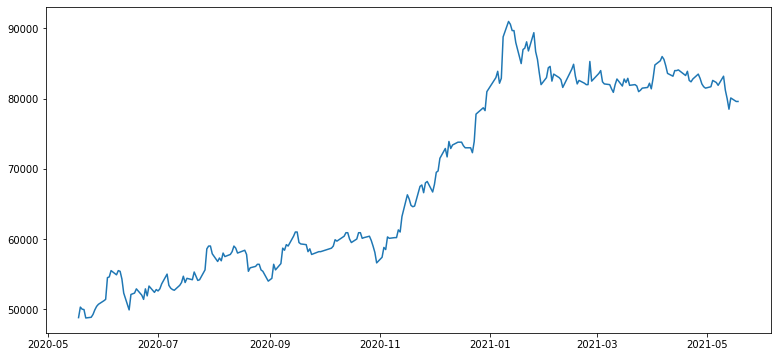

In [3]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정
plt.plot(ts) # 시계열(time series) 데이터를 차트로 시각화

## STEP 2 : 각종 전처리 수행

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

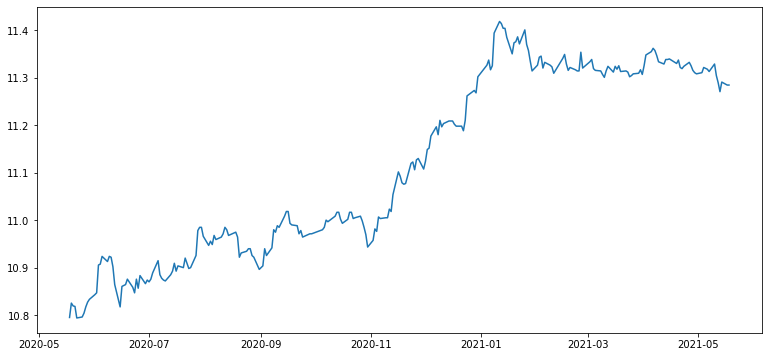

In [5]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [6]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

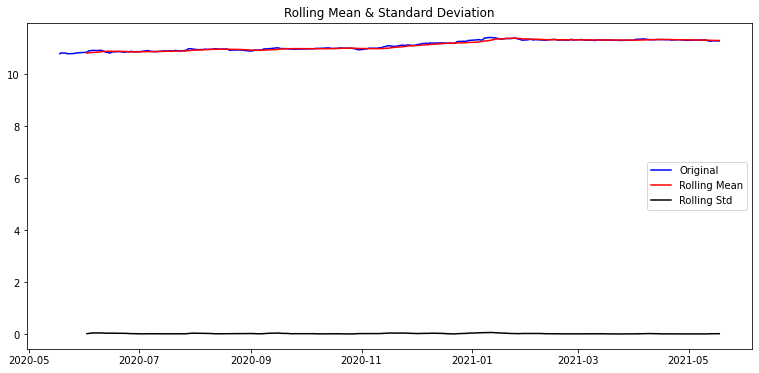

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


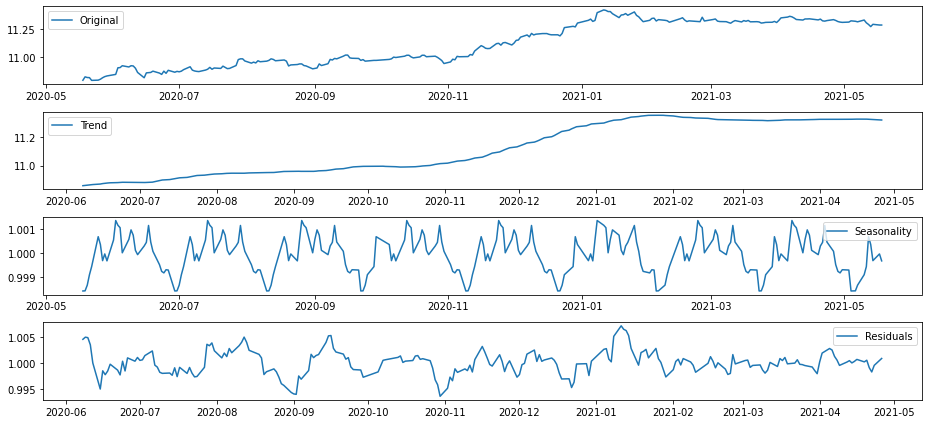

In [10]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

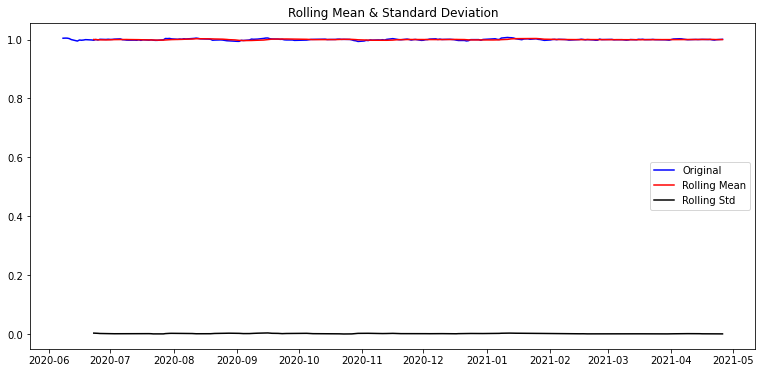

In [11]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

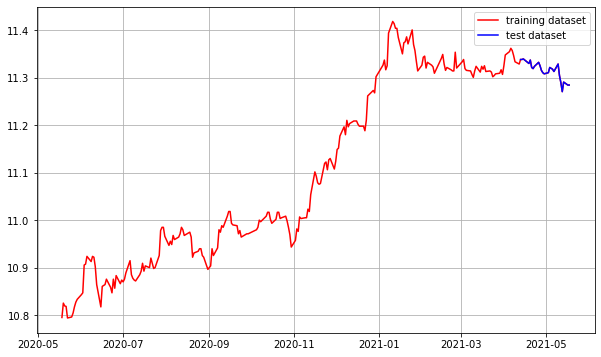

In [13]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


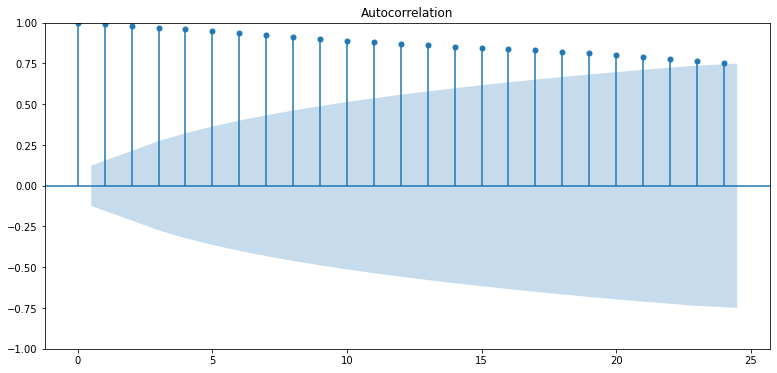

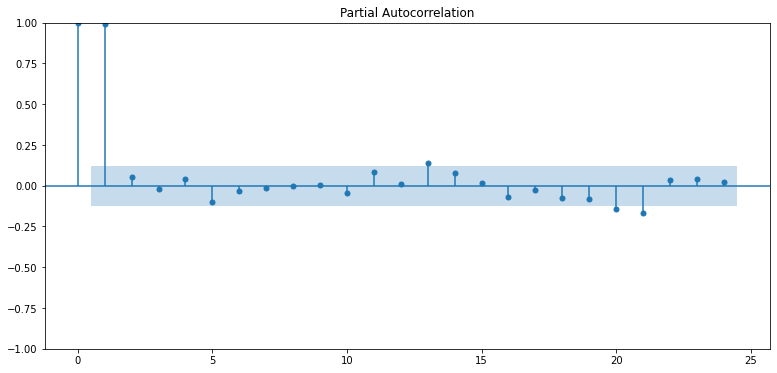

In [14]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


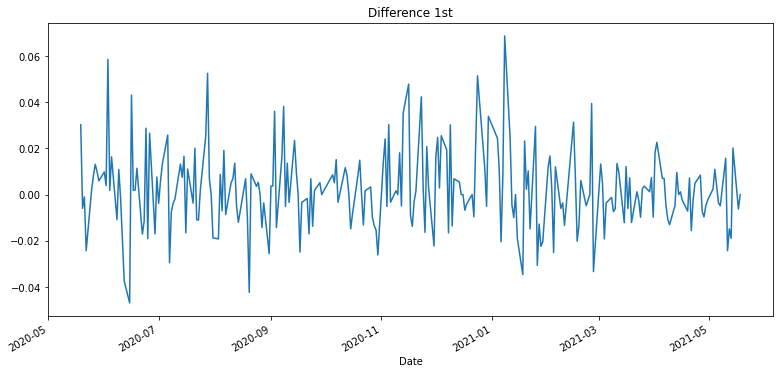

In [15]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


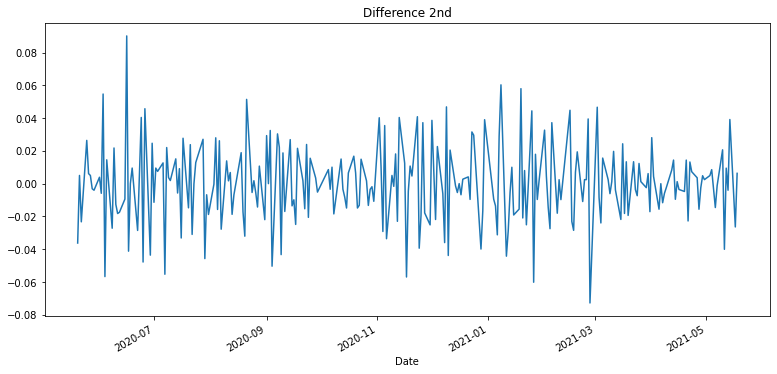

In [16]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트


In [18]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        01:18:16   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


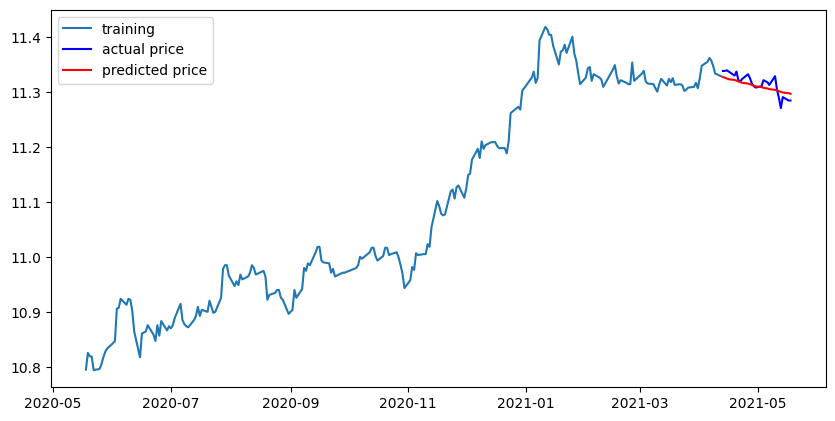

In [19]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


## STEP 7 : 다른 주식 종목 예측해 보기

In [22]:
def get_time_series_log(filename):
    # Time Series 생성
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/data'
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    # 결측치 처리
    if len(ts[ts.isna()]) > 0:
        ts = ts.interpolate(method='time')
    # 로그 변환
    return np.log(ts)

In [23]:
def check_stationary(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)
    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

In [24]:
def time_series_decomposition(ts_log):
    # 시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

In [25]:
def split_train_test_data(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

In [26]:
# ACF, PACF 그려보기 -> p,q 구하기
def plot_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [27]:
# 차분 안정성 확인 -> d 구하기
def get_difference(ts_log):
    # 1차 차분 구하기
    plt.subplot(211)
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    # 혹시 필요한 경우 2차 차분 구하기
    plt.subplot(212)
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    print('Difference 1st:')
    augmented_dickey_fuller_test(diff_1)
    print('\nDifference 2nd:')
    augmented_dickey_fuller_test(diff_2)

In [28]:
def arima_train_test(order):
    # Build and Train  Model
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # Score
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

### 7-1 애플 예측

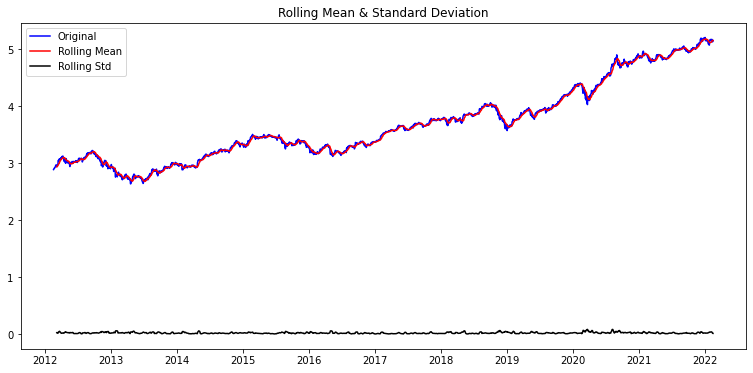

Results of Dickey-Fuller Test:
Test Statistic                    0.707177
p-value                           0.989980
#Lags Used                       14.000000
Number of Observations Used    2502.000000
Critical Value (1%)              -3.432966
Critical Value (5%)              -2.862696
Critical Value (10%)             -2.567385
dtype: float64


In [31]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('AAPL.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

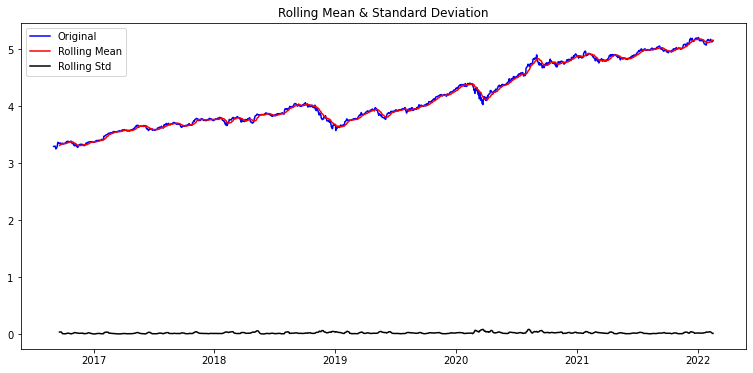

Results of Dickey-Fuller Test:
Test Statistic                   -0.101262
p-value                           0.949313
#Lags Used                        9.000000
Number of Observations Used    1364.000000
Critical Value (1%)              -3.435153
Critical Value (5%)              -2.863661
Critical Value (10%)             -2.567899
dtype: float64


In [32]:
# 기간 조정
ts_log = ts_log['2016-09-02':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -9.924835e+00
p-value                        2.925600e-17
#Lags Used                     1.900000e+01
Number of Observations Used    1.324000e+03
Critical Value (1%)           -3.435299e+00
Critical Value (5%)           -2.863725e+00
Critical Value (10%)          -2.567934e+00
dtype: float64


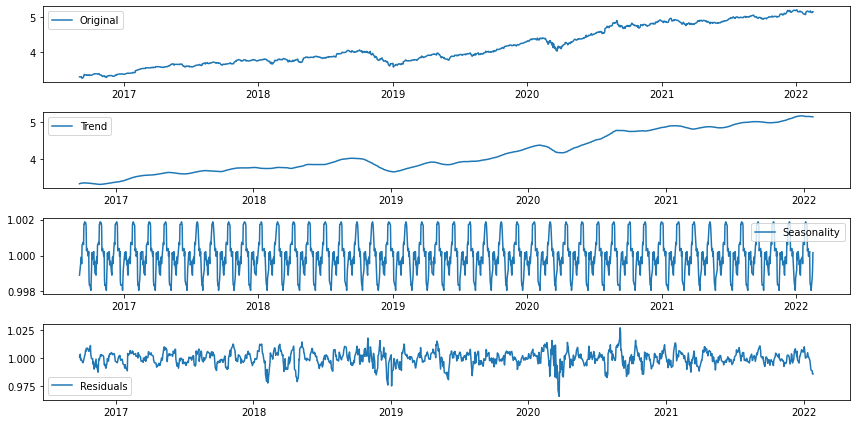

In [33]:
# 시계열 분해
time_series_decomposition(ts_log)

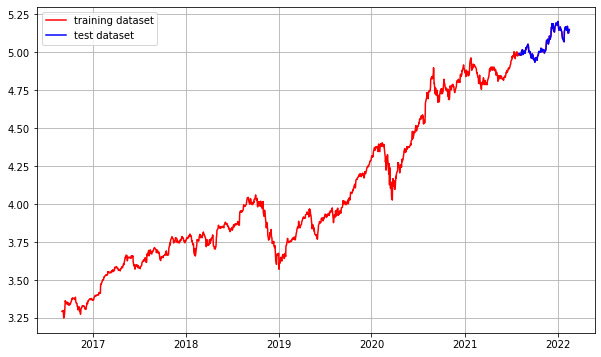

In [34]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


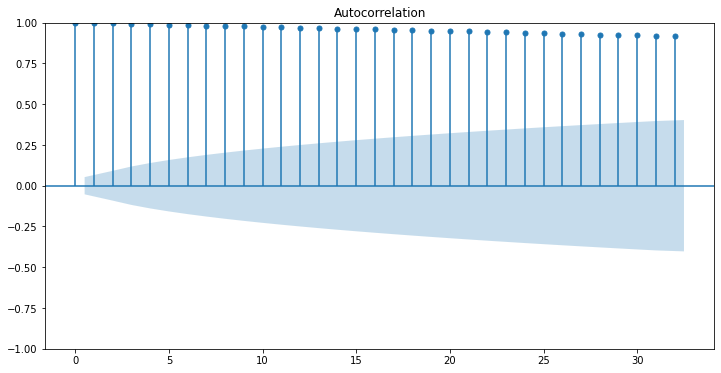

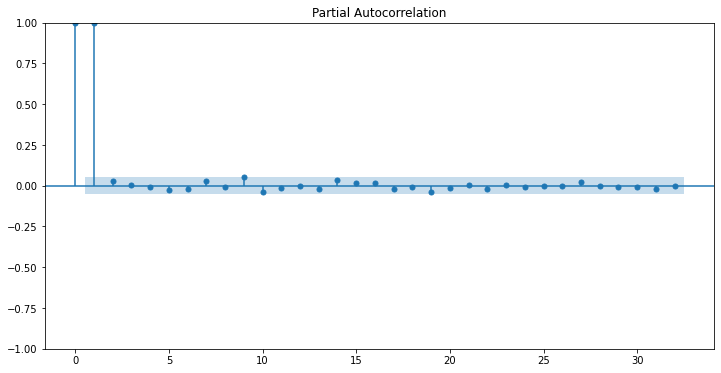

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.180083e+01
p-value                        9.339663e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.364000e+03
Critical Value (1%)           -3.435153e+00
Critical Value (5%)           -2.863661e+00
Critical Value (10%)          -2.567899e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.611569e+01
p-value                        4.958764e-29
#Lags Used                     1.700000e+01
Number of Observations Used    1.354000e+03
Critical Value (1%)           -3.435189e+00
Critical Value (5%)           -2.863677e+00
Critical Value (10%)          -2.567908e+00
dtype: float64


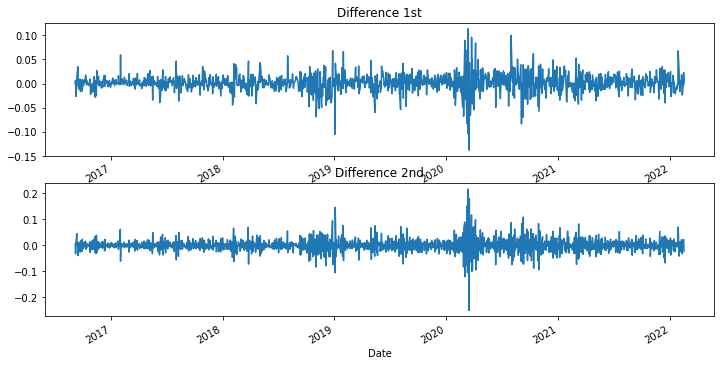

In [36]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

In [40]:
model = ARIMA(train_data, order=(3, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                3137.340
Date:                Thu, 17 Feb 2022   AIC                          -6264.680
Time:                        01:31:25   BIC                          -6239.086
Sample:                             0   HQIC                         -6255.053
                               - 1236                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0619      3.486     -0.018      0.986      -6.895       6.771
ar.L2          0.0297      0.417      0.071      0.943      -0.788       0.847
ar.L3         -0.0072      0.086     -0.084      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


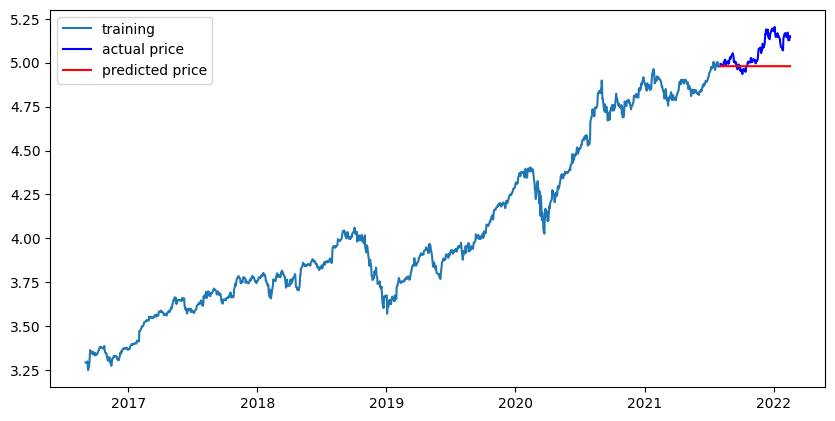

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()



In [42]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  310.6371081665661
MAE:  13.265877691915978
RMSE:  17.62490023139326
MAPE: 7.89%


## 7-2 테슬라 예측

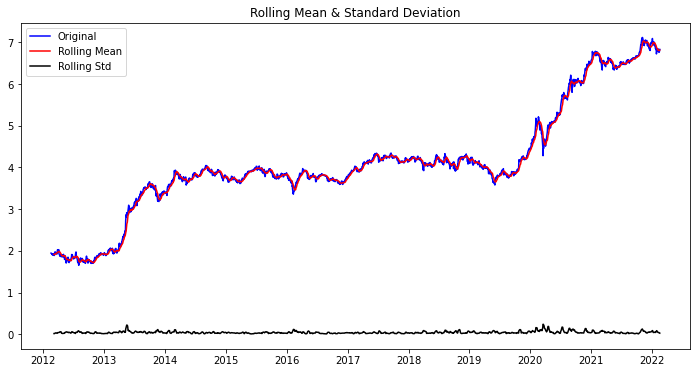

Results of Dickey-Fuller Test:
Test Statistic                   -0.080470
p-value                           0.951349
#Lags Used                        0.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64


In [44]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('TSLA.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

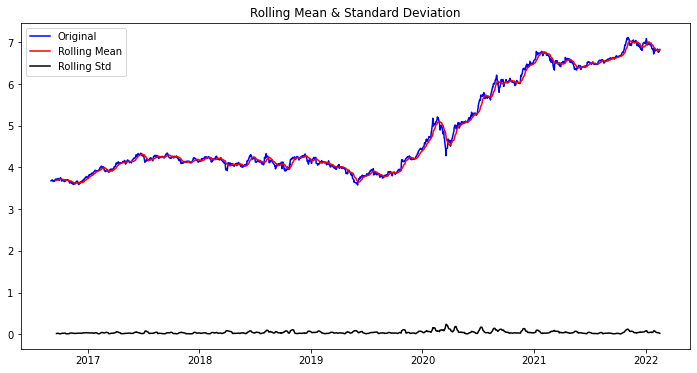

Results of Dickey-Fuller Test:
Test Statistic                    0.196075
p-value                           0.972041
#Lags Used                        0.000000
Number of Observations Used    1373.000000
Critical Value (1%)              -3.435122
Critical Value (5%)              -2.863647
Critical Value (10%)             -2.567892
dtype: float64


In [45]:
# 기간 조정
ts_log = ts_log['2016-09-02':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.111457e+01
p-value                        3.589853e-20
#Lags Used                     1.800000e+01
Number of Observations Used    1.325000e+03
Critical Value (1%)           -3.435295e+00
Critical Value (5%)           -2.863724e+00
Critical Value (10%)          -2.567933e+00
dtype: float64


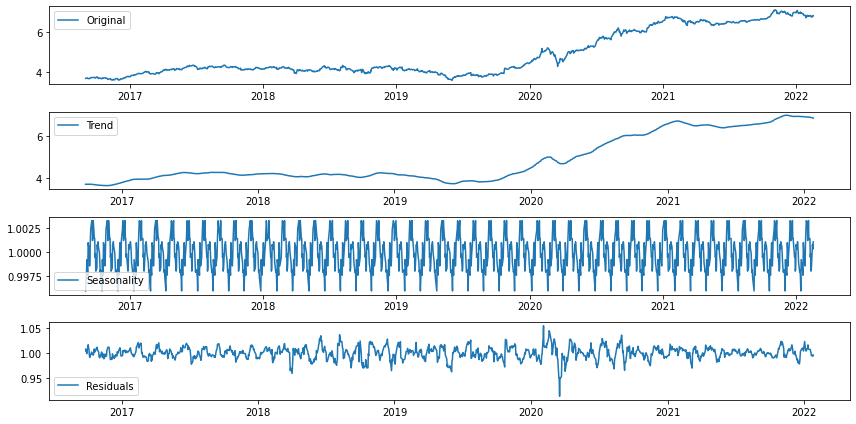

In [46]:
# 시계열 분해
time_series_decomposition(ts_log)

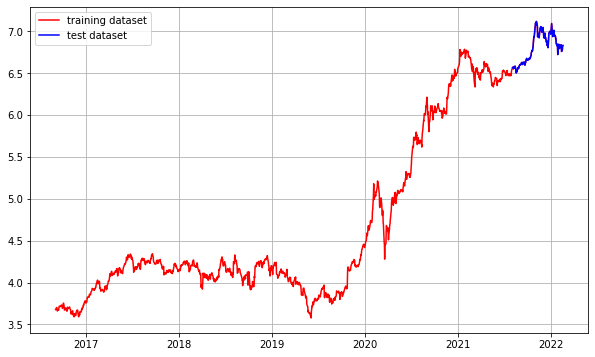

In [47]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


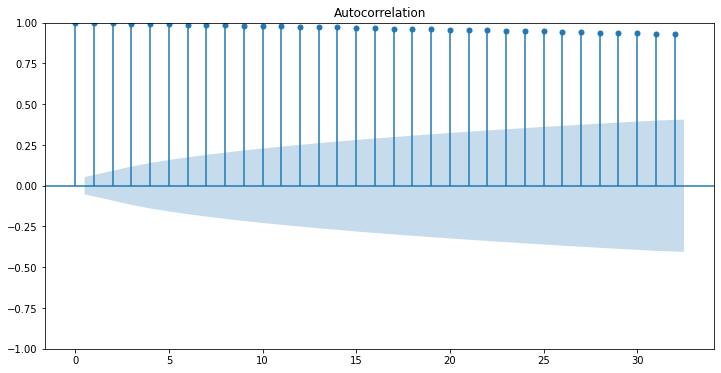

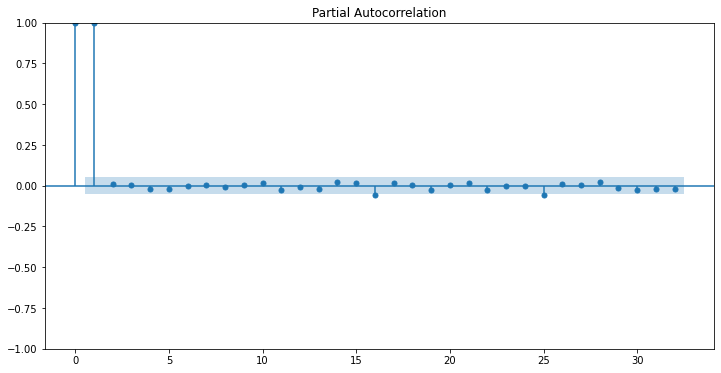

In [48]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                  -37.584727
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1372.000000
Critical Value (1%)              -3.435125
Critical Value (5%)              -2.863649
Critical Value (10%)             -2.567893
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.297985e+01
p-value                        2.959451e-24
#Lags Used                     2.300000e+01
Number of Observations Used    1.348000e+03
Critical Value (1%)           -3.435210e+00
Critical Value (5%)           -2.863686e+00
Critical Value (10%)          -2.567913e+00
dtype: float64


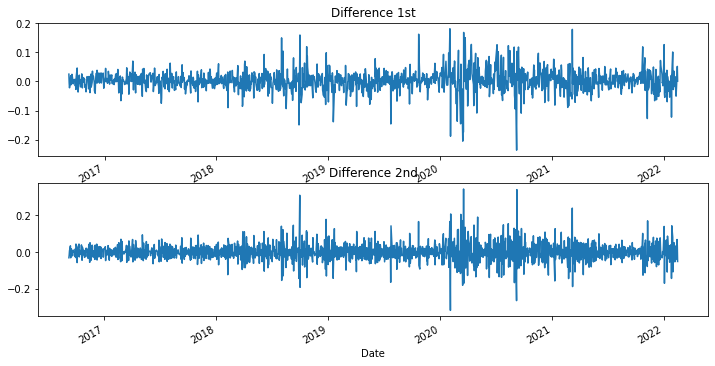

In [49]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

In [50]:
model = ARIMA(train_data, order=(3, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                2305.205
Date:                Thu, 17 Feb 2022   AIC                          -4600.411
Time:                        01:37:22   BIC                          -4574.817
Sample:                             0   HQIC                         -4590.783
                               - 1236                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0063      0.455     -0.014      0.989      -0.898       0.885
ar.L2          0.0440      0.019      2.299      0.022       0.006       0.081
ar.L3          0.0484      0.026      1.825      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


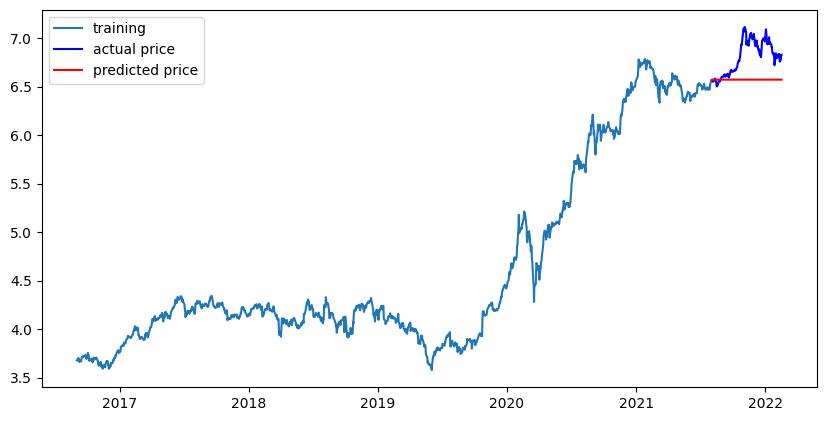

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [52]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  64509.31004034753
MAE:  203.14366169277244
RMSE:  253.98683044667402
MAPE: 19.98%


## 7-3 KB 국민은행

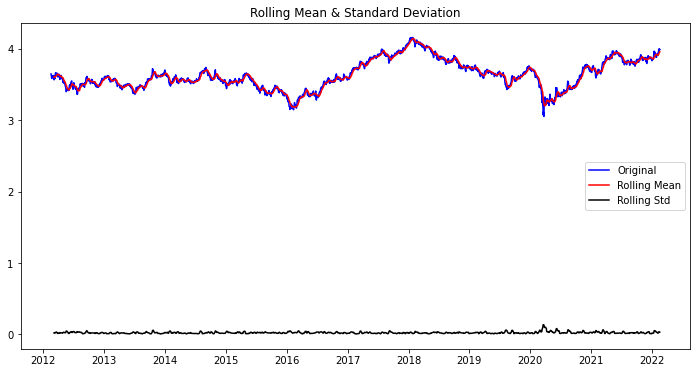

Results of Dickey-Fuller Test:
Test Statistic                   -1.778162
p-value                           0.391356
#Lags Used                        9.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64


In [54]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('KB.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

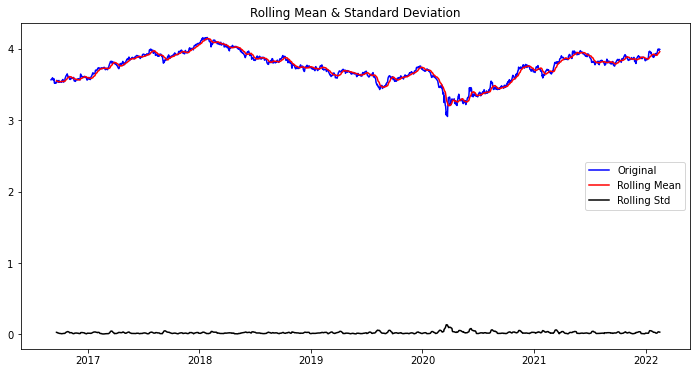

Results of Dickey-Fuller Test:
Test Statistic                   -1.573161
p-value                           0.497060
#Lags Used                        9.000000
Number of Observations Used    1364.000000
Critical Value (1%)              -3.435153
Critical Value (5%)              -2.863661
Critical Value (10%)             -2.567899
dtype: float64


In [55]:
# 기간 조정
ts_log = ts_log['2016-09-02':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.457344e+01
p-value                        4.589166e-27
#Lags Used                     9.000000e+00
Number of Observations Used    1.334000e+03
Critical Value (1%)           -3.435261e+00
Critical Value (5%)           -2.863709e+00
Critical Value (10%)          -2.567925e+00
dtype: float64


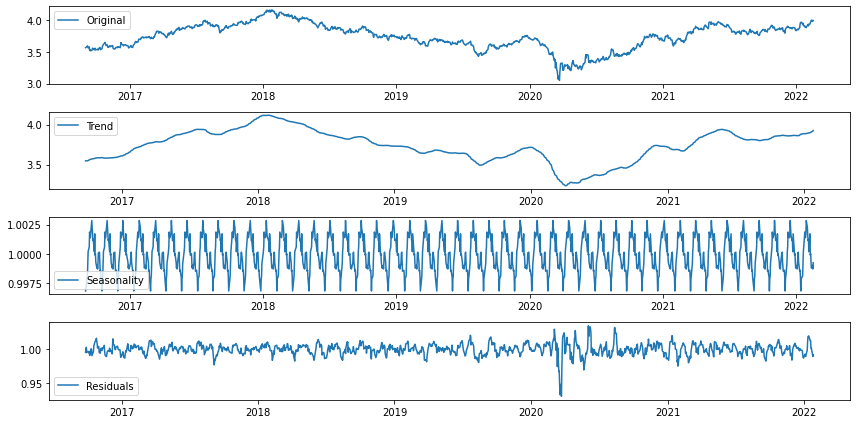

In [56]:
# 시계열 분해
time_series_decomposition(ts_log)

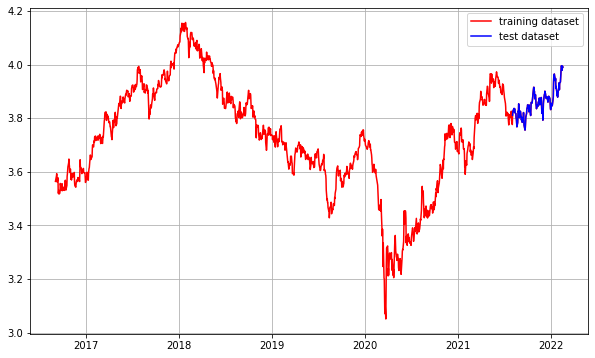

In [57]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


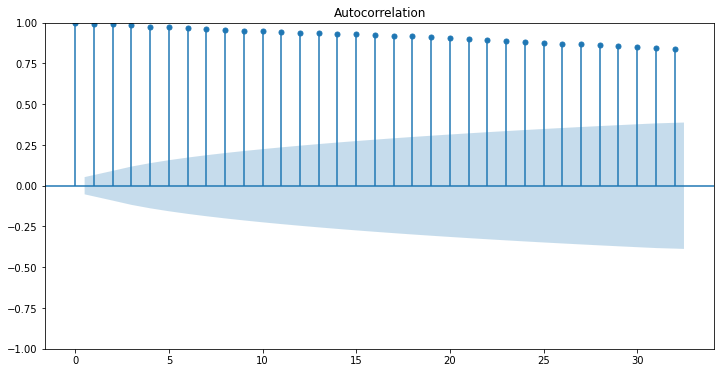

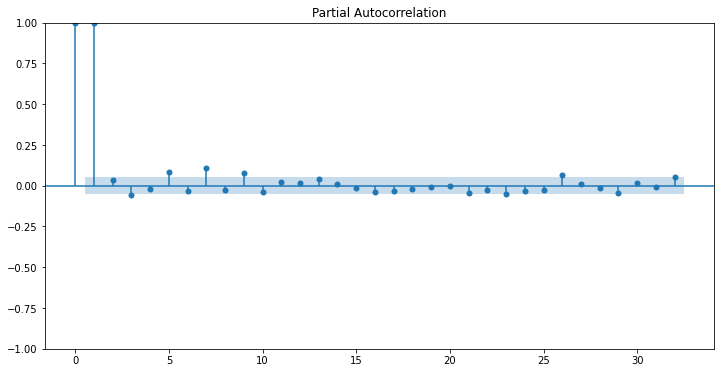

In [58]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.489445e+01
p-value                        1.539849e-27
#Lags Used                     7.000000e+00
Number of Observations Used    1.365000e+03
Critical Value (1%)           -3.435150e+00
Critical Value (5%)           -2.863660e+00
Critical Value (10%)          -2.567899e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.473656e+01
p-value                        2.610033e-27
#Lags Used                     2.200000e+01
Number of Observations Used    1.349000e+03
Critical Value (1%)           -3.435207e+00
Critical Value (5%)           -2.863685e+00
Critical Value (10%)          -2.567912e+00
dtype: float64


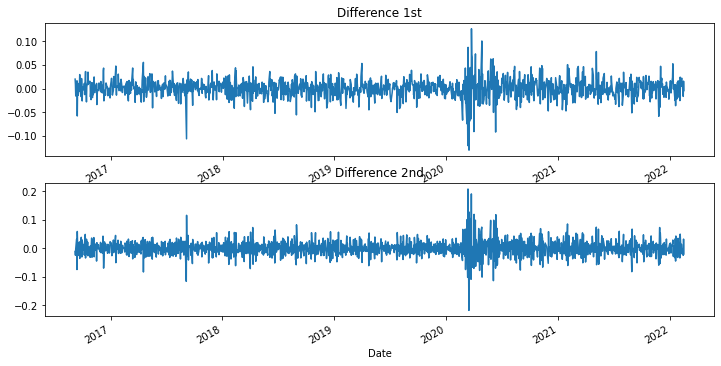

In [59]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

In [61]:
model = ARIMA(train_data, order=(1, 2, 3))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1236
Model:                 ARIMA(1, 2, 3)   Log Likelihood                3061.609
Date:                Thu, 17 Feb 2022   AIC                          -6113.218
Time:                        01:42:25   BIC                          -6087.628
Sample:                             0   HQIC                         -6103.592
                               - 1236                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9645      0.028    -34.879      0.000      -1.019      -0.910
ma.L1         -0.0589      0.029     -1.997      0.046      -0.117      -0.001
ma.L2         -0.9755      0.021    -47.094      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


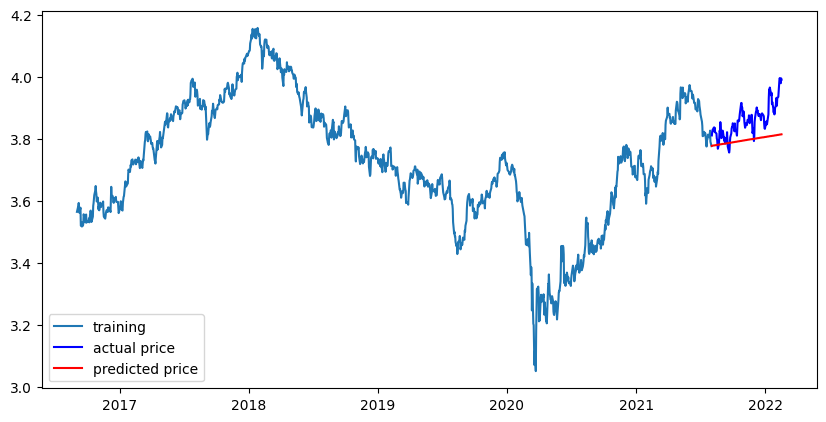

In [62]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [63]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  13.408315292266533
MAE:  3.0396655022007364
RMSE:  3.6617366497696873
MAPE: 6.20%


## 결과

변동성이 큰 회사일수록 MAPE값이 크게 나오는 걸 알 수 있다. 하지만 변동이 적은 금융권이나 꾸준히 상승하는 모습을 보여주는 삼성과 애플같은 대기업도 오차가 적게 나오는 걸 알 수 있다.

이로써 아직까지 주가예측모델은 큰 활용도가 부족한걸 알 수 있다.